Предварительное преобразование данных может быть обусловлено следующими причинами:  
- необходимо проецировать точки данных на плоскость (для этого нужно выделить или "придумать" два признака, которые бы с некоторой точностью характеризовали исходные данные **большей** размерности)  
- необходимо "сжать" данные, потому что пространтсво признаков слишком большое  
- нужно из всех признаков выделить такие знания, которые давали бы больше информации для дальнейших исследований

# Анализ главных компонент
**PCA - Principal Component Analysis** - метод, который осуществляет вращение данных с той целью, чтобы преобразованные признаки *не коррелировали* между собой. Часто это вращение сопровождается выбором подмножества новых признаков в зависимости от их важности с точки зрения интерпретации данных.  

## Выделение главных компонент и визуализация
Рассмотрим применение PCA на примере задачи классификации доброкачественной и злокачественной опухоли (набор данных breast_cancer). Посколько всего 30 признаков, то будет трудно посмотреть на диаграммы рассеивания (они бы показали, как коррелируют между собой пары признаков; их было бы 420 штук). Вместо этого можно построить гистограммы значений признаков для возможных классов (их всего 2)

In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

cancer = load_breast_cancer()
print('Классы: ', cancer.target_names)
X_train, X_test, y_train, y_test = train_test_split(cancer.data,
                                                   cancer.target,
                                                   random_state=19)
print(f'Распределение по классам: \n \
     - Тренировочная: {len(y_train[y_train==0])}({cancer.target_names[0]}) и {len(y_train[y_train==1])}({cancer.target_names[1]}) \n \
     - Тестовая: {len(y_test[y_test==0])}({cancer.target_names[0]}) и {len(y_test[y_test==1])}({cancer.target_names[1]})')

Классы:  ['malignant' 'benign']
Распределение по классам: 
      - Тренировочная: 154(malignant) и 272(benign) 
      - Тестовая: 58(malignant) и 85(benign)


Text(0.5, 0, 'Значение признака (дискретизированное интервалами)')

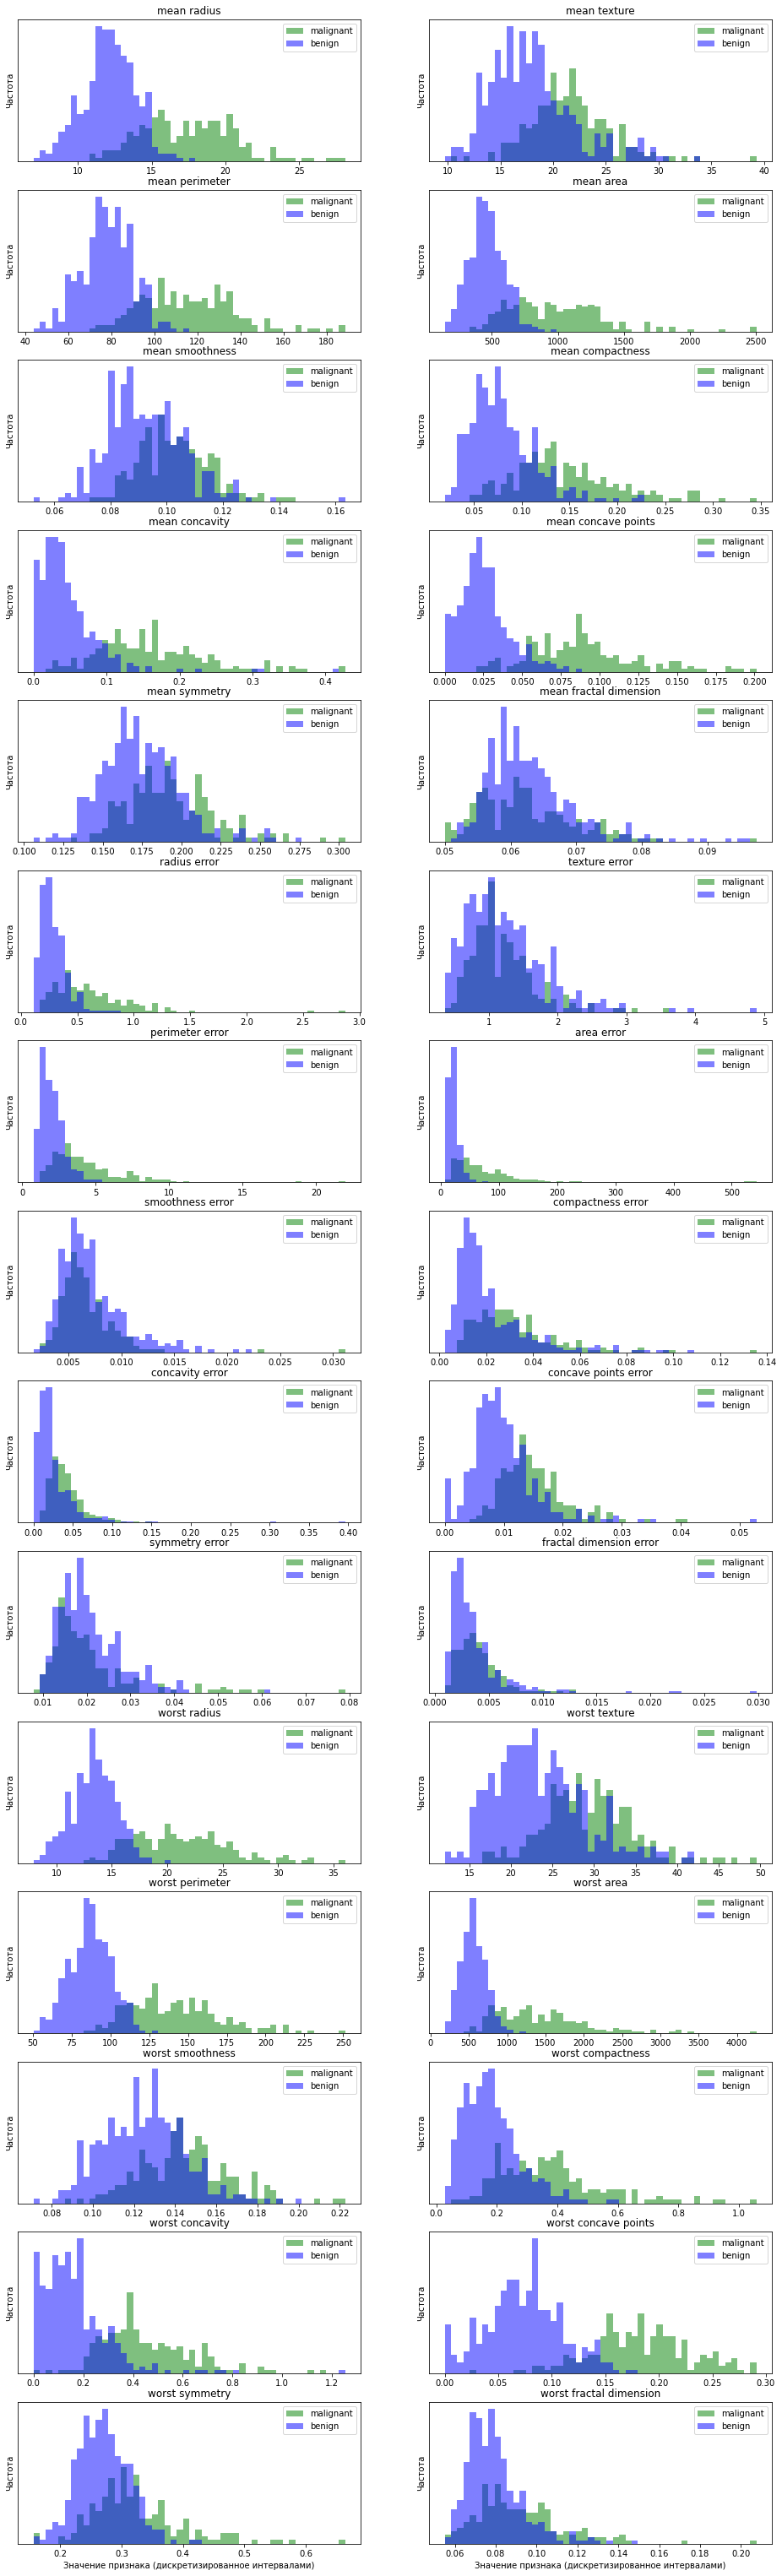

In [2]:
fig, axes = plt.subplots(15, 2, figsize=(16, 55))

# отделим точки данных разных классов во всем датасете
malignant = cancer.data[cancer.target==0]
benign = cancer.data[cancer.target==1]

ax = axes.ravel()

for i in range(30):
    # поскольку данные - это выборка непрерывной СВ, то
    # дискретизируем её путем интервального разбиения
    _, bins = np.histogram(cancer.data[:, i], bins=50)
    ax[i].hist(malignant[:, i], bins=bins, color='g', alpha=.5)
    ax[i].hist(benign[:, i], bins=bins, color='b', alpha=.5)
    ax[i].set_title(cancer.feature_names[i])
    ax[i].set_yticks(())
    ax[i].set_ylabel("Частота")
    ax[i].legend(["malignant", "benign"], loc="upper right")    
ax[28].set_xlabel("Значение признака (дискретизированное интервалами)")
ax[29].set_xlabel("Значение признака (дискретизированное интервалами)")

В данном случае мы строим гистограмму для каждого признака, подсчитывая частату встречаемости точек данных в пределах границ интервалов, на которые мы разбили непрерывные признаки. По этой гистограмме можно судить о том, какие признаки *хорошо* разделяют наши классы  
*Признаки mean smoothness, mean fractial dimension, mean symmetry малоинформативны для наших целей. С другой стороны, признаки mean/worst area, mean/worst perimeter, worst concave points достаточно информативны, поскольку хорошо отделяют один класс от другого.*

Мы провели ручное исследования, выявив некоторые зависимости. Алгоритм PCA позволяет учесть главные взаимодействия в данных и построить более полную картину завимостей (алгоритм учитывает связь между признакими, между признаками и классами)

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# простой препроцессинг: отмасштабируем данные
scaler = StandardScaler()
X_scaled = scaler.fit_transform(cancer.data)
print(f'Размер всего набора данных: {X_scaled.shape}')

# попытаемся выделить 2 компоненты 
# (спроецировать точки данных из 30-мерного пространства на плоскость)
pca = PCA(n_components=2)
pca.fit(X_scaled)
X_scaled_pca = pca.transform(X_scaled)
print(f'Размер набора данных после анализа компонент: {X_scaled_pca.shape}')

Размер всего набора данных: (569, 30)
Размер набора данных после анализа компонент: (569, 2)


Text(0, 0.5, 'Вторая выделенная главная компонента')

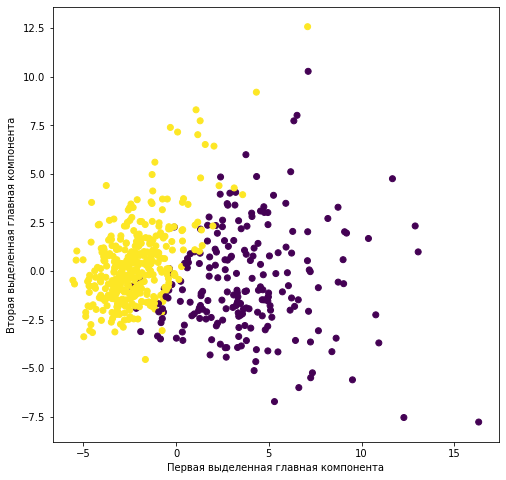

In [4]:
# теперь мы в прямом смысле можем визуализировать наши данные
plt.figure(figsize=(8, 8))
plt.scatter(X_scaled_pca[:, 0], X_scaled_pca[:, 1], c=cancer.target)

plt.xlabel('Первая выделенная главная компонента')
plt.ylabel('Вторая выделенная главная компонента')

Можно отметить, что полученные две компоненты отлично разделяют наши данные (можно заметить, что достаточно провести прямую линию, чтобы с большой точностью отделить один класс от другого => с этой задачей справится линейный классификатор)

**Анализ главных компонент** анализирует корреляционные связи в данных. Выделяемые главные компоненты суть комбинации признаков. Эти комбинации могут быть очень сложны. Можно посмотреть на "важность" каждого признака для каждой компоненты:

Форма компонент: (2, 30)


Text(0, 0.5, 'Выделенные главные компоненты')

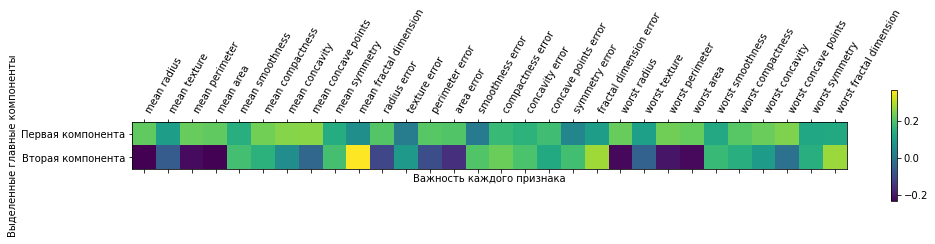

In [5]:
print(f'Форма компонент: {pca.components_.shape}')

plt.matshow(pca.components_, cmap='viridis')
plt.colorbar()
plt.yticks([0, 1], ['Первая компонента', 'Вторая компонента'])
plt.xticks(range(len(cancer.feature_names)), cancer.feature_names,
           rotation=60, ha='left')
plt.xlabel('Важность каждого признака')
plt.ylabel('Выделенные главные компоненты')

Стоит отметить, что в результате PCA **всегда получаются ортогональные друг другу компоненты** (вне зависимости от того, сколько их)

## Выделение признаков (метод "собственных лиц" - eigenfaces)
Идея, лежащая в основе выделения признаков, заключается в поиске нового представления данных, которое в отличие от исходного лучше подходит для анализа.

Отличный пример: работа с изображениями. Изображения состоят из тысячи пикселей, которые представляют собой интенсивность трех каналов (RGB). Лишь все вместе эти пиксели дают какую-то информацию (то есть лишь объединив все пиксели мы получим исходное изображение). Можно ли из тысячи пикселей **выделить главные признаки**?

In [10]:
from sklearn.datasets import fetch_lfw_people
# датасет с изображением лиц знаменитостей
people = fetch_lfw_people()

URLError: <urlopen error [Errno 11001] getaddrinfo failed>

# Факторизация неотрицательных матриц
NMF - алгоритм машинного обучения без учителя, цель которого - выделить полезные характеристики (выделение новые признаков). Он работает почти так же, как и PCA, поэтому его можно использовать для тех же целей (уменьшение размерности, выделение главных компонент и т.д.). *Различие между NMF и PCA* заключается в том, что в PCA нужно получить ортогональные компоненты, объясняющие максимально возможную долю дисперсии данных, в то время как в NMF нужно получить неотрицательные компоненты и коэффициенты. По этой причине метод NMF применяется лишь к тем данным, в которых характеристики имеют неотрицательные значения

# Алгоритм t-SNE